# Single Beam
This notebook will run the ISR simulator with a set of data created from a function that makes test data. The results along with error bars are plotted below.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os,inspect
from SimISR import Path
import scipy as sp
from SimISR.utilFunctions import readconfigfile,makeconfigfile
from SimISR.IonoContainer import IonoContainer,MakeTestIonoclass
from SimISR.runsim import main as runsim 
from SimISR.analysisplots import analysisdump
import seaborn as sns

/Users/Bodangles/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Set up Config Files
Setting up a configuration files and the directory needed to run the simulation. The simualtor assumes that for each simulation there is a dedicated directory to save out data along the different processing stages. The simulator also assumes that there is a configuration file which is created in the following cell using a default one that comes with the code base. The only parameter the user should have to set is the number of pulses.

In [2]:
# set the number of pulses
npulses = 2000
curloc = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
testpath = os.path.join(os.path.split(curloc)[0],'Testdata','Notebookexample1')
if not os.path.isdir(testpath):
    os.mkdir(testpath)

defaultpath = os.path.join(os.path.split(curloc)[0],'Test')
defcon = os.path.join(defaultpath,'statsbase.ini')
(sensdict,simparams) = readconfigfile(defcon)

tint = simparams['IPP']*npulses
ratio1 = tint/simparams['Tint']
simparams['Tint']=ratio1 * simparams['Tint']
simparams['Fitinter'] = ratio1 * simparams['Fitinter']
simparams['TimeLim'] = tint

simparams['startfile']='startfile.h5'
makeconfigfile(os.path.join(testpath,'stats.ini'),simparams['Beamlist'],sensdict['Name'],simparams)

/Users/Bodangles/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/Bodangles/Documents/Python/SimISR/SimISR/utilFunctions.py:698: UserWarning: No start file given
  warnings.warn('No start file given',UserWarning)


## Make Input Data
This section will create a set of input parmeters that can be used to create ISR Data. It uses a function MakeTestIonoclass which will create a set of plasma parameters that varies with altitude depending on the the function inputs. This data is put into an ionocontainer class, which is used as a container class to move data between the radarData class, fitter class and plotting modules. It has a standard format so any radar data or plasma parameters for the simulator can be saved in this.

A start file is also made which will be used as the starting parameter values used in the fitter. The starting points for the fitter use a nearest neighbor in space to what is found in the start file.

In [3]:

finalpath = os.path.join(testpath,'Origparams')
if not os.path.isdir(finalpath):
    os.mkdir(finalpath)
z = (50.+sp.arange(120)*5.)
nz = len(z)
coords = sp.column_stack((sp.zeros((nz,2)),z))
Icont1=MakeTestIonoclass(testv=False,testtemp=True,N_0=1e11,z_0=250.0,H_0=50.0,coords=coords,times =sp.array([[0,1e6]]))

Icontstart = MakeTestIonoclass(testv=False,testtemp=False,N_0=1e11,z_0=250.0,H_0=50.0,coords=coords,times =sp.array([[0,1e6]]))

finalfile = os.path.join(finalpath,'0 stats.h5')
Icont1.saveh5(finalfile)
Icontstart.saveh5(os.path.join(testpath,'startfile.h5'))

## Run Simulation
The simulation is run through the submodule runsim and its main function, renamed in this as runsim. This function will call all of the neccesary classes and functions to run the simulator. It will save out the data based off of an internal set of file names.

This function must get a configuration file and a list of functionalities it is to perform. Below the runsim function will create spectra form the plasma parameters, create radar data and then fit it.

In [4]:
functlist = ['spectrums','radardata','fitting']

config = os.path.join(testpath,'stats.ini')

runsim(functlist,testpath,config,True)

Processing file 0 stats.h5 starting at 2016-12-03 18:17:42.603779

	 Time:0 of 1 Location:0 of 120, now making spectrum.
	 Time:0 of 1 Location:1 of 120, now making spectrum.
	 Time:0 of 1 Location:2 of 120, now making spectrum.
	 Time:0 of 1 Location:3 of 120, now making spectrum.
	 Time:0 of 1 Location:4 of 120, now making spectrum.
	 Time:0 of 1 Location:5 of 120, now making spectrum.
	 Time:0 of 1 Location:6 of 120, now making spectrum.
	 Time:0 of 1 Location:7 of 120, now making spectrum.
	 Time:0 of 1 Location:8 of 120, now making spectrum.
	 Time:0 of 1 Location:9 of 120, now making spectrum.
	 Time:0 of 1 Location:10 of 120, now making spectrum.
	 Time:0 of 1 Location:11 of 120, now making spectrum.
	 Time:0 of 1 Location:12 of 120, now making spectrum.
	 Time:0 of 1 Location:13 of 120, now making spectrum.
	 Time:0 of 1 Location:14 of 120, now making spectrum.
	 Time:0 of 1 Location:15 of 120, now making spectrum.
	 Time:0 of 1 Location:16 of 120, now making spectrum.
	 Time:0

/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  outspecs = sp.zeros((N_x,N_t,npts))


	 Time:0 of 1 Location:18 of 120, now making spectrum.
	 Time:0 of 1 Location:19 of 120, now making spectrum.
	 Time:0 of 1 Location:20 of 120, now making spectrum.
	 Time:0 of 1 Location:21 of 120, now making spectrum.
	 Time:0 of 1 Location:22 of 120, now making spectrum.
	 Time:0 of 1 Location:23 of 120, now making spectrum.
	 Time:0 of 1 Location:24 of 120, now making spectrum.
	 Time:0 of 1 Location:25 of 120, now making spectrum.
	 Time:0 of 1 Location:26 of 120, now making spectrum.
	 Time:0 of 1 Location:27 of 120, now making spectrum.
	 Time:0 of 1 Location:28 of 120, now making spectrum.
	 Time:0 of 1 Location:29 of 120, now making spectrum.
	 Time:0 of 1 Location:30 of 120, now making spectrum.
	 Time:0 of 1 Location:31 of 120, now making spectrum.
	 Time:0 of 1 Location:32 of 120, now making spectrum.
	 Time:0 of 1 Location:33 of 120, now making spectrum.
	 Time:0 of 1 Location:34 of 120, now making spectrum.
	 Time:0 of 1 Location:35 of 120, now making spectrum.
	 Time:0 o

/Users/Bodangles/anaconda/lib/python2.7/site-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


		 Making Beam 0 of 1
Forming ACF estimates
	Time 0 of 1
		Beam 0 of 0

Data Now being fit.
	Data for time 0 of 1 now being fit.
	 Time:0 of 1 Location:0 of 156 now being fit.
	 Time:0 of 1 Location:1 of 156 now being fit.


/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:134: RuntimeWarning: overflow encountered in exp
  grt0 = sp.exp(-datablock)
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:394: ComplexWarning: Casting complex values to real discards the imaginary part
  nuperp[-1] = nuei +nuee
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:395: ComplexWarning: Casting complex values to real discards the imaginary part
  nuparr[-1] = nuei
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:399: ComplexWarning: Casting complex values to real discards the imaginary part
  nuparr[si]=nuparr[si]+Bst[s][t]*Ni[ti]/sp.power(Ti[ti],1.5)
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:247: RuntimeWarning: overflow encountered in exp
  gord = (sp.sqrt(sp.pi)*sp.exp(-theta**2)-1j*2.0*scipy.special.dawsn(theta))/(K*C*sp.sqrt(2))
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:2

	 Time:0 of 1 Location:2 of 156 now being fit.
	 Time:0 of 1 Location:3 of 156 now being fit.


/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:171: RuntimeWarning: overflow encountered in double_scalars
  penadd = sp.sqrt(sp.power(sp.absolute(yout),2).sum())*pentsum.sum()
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:138: RuntimeWarning: overflow encountered in divide
  sig_i = (Ni/Ne)*(1j+omeg_i*igord)/(self.K**2*mu*h_e**2/qrot**2)


	 Time:0 of 1 Location:4 of 156 now being fit.
	 Time:0 of 1 Location:5 of 156 now being fit.
	 Time:0 of 1 Location:6 of 156 now being fit.


/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:150: RuntimeWarning: invalid value encountered in divide
  guess_acf = guess_acf*rcs/guess_acf[0].real


	 Time:0 of 1 Location:7 of 156 now being fit.


/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:150: RuntimeWarning: invalid value encountered in multiply
  enum = sp.absolute(1j+sig_sum)**2*nte


	 Time:0 of 1 Location:8 of 156 now being fit.
	 Time:0 of 1 Location:9 of 156 now being fit.
	 Time:0 of 1 Location:10 of 156 now being fit.


/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:149: RuntimeWarning: overflow encountered in square
  inum = sp.absolute(sig_e)**2*nt_sum
/Users/Bodangles/Documents/Python/SimISR/SimISR/specfunctions.py:150: RuntimeWarning: overflow encountered in divide
  guess_acf = guess_acf*rcs/guess_acf[0].real


	 Time:0 of 1 Location:11 of 156 now being fit.
	 Time:0 of 1 Location:12 of 156 now being fit.
	 Time:0 of 1 Location:13 of 156 now being fit.
	 Time:0 of 1 Location:14 of 156 now being fit.
	 Time:0 of 1 Location:15 of 156 now being fit.
	 Time:0 of 1 Location:16 of 156 now being fit.


/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:138: RuntimeWarning: overflow encountered in multiply
  sig_i = (Ni/Ne)*(1j+omeg_i*igord)/(self.K**2*mu*h_e**2/qrot**2)
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:138: RuntimeWarning: invalid value encountered in multiply
  sig_i = (Ni/Ne)*(1j+omeg_i*igord)/(self.K**2*mu*h_e**2/qrot**2)
/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:138: RuntimeWarning: invalid value encountered in divide
  sig_i = (Ni/Ne)*(1j+omeg_i*igord)/(self.K**2*mu*h_e**2/qrot**2)


	 Time:0 of 1 Location:17 of 156 now being fit.
	 Time:0 of 1 Location:18 of 156 now being fit.
	 Time:0 of 1 Location:19 of 156 now being fit.
	 Time:0 of 1 Location:20 of 156 now being fit.
	 Time:0 of 1 Location:21 of 156 now being fit.
	 Time:0 of 1 Location:22 of 156 now being fit.
	 Time:0 of 1 Location:23 of 156 now being fit.
	 Time:0 of 1 Location:24 of 156 now being fit.
	 Time:0 of 1 Location:25 of 156 now being fit.
	 Time:0 of 1 Location:26 of 156 now being fit.
	 Time:0 of 1 Location:27 of 156 now being fit.
	 Time:0 of 1 Location:28 of 156 now being fit.
	 Time:0 of 1 Location:29 of 156 now being fit.


/Users/Bodangles/Documents/Python/ISRSpectrum/ISRSpectrum/ISRSpectrum.py:247: RuntimeWarning: overflow encountered in subtract
  gord = (sp.sqrt(sp.pi)*sp.exp(-theta**2)-1j*2.0*scipy.special.dawsn(theta))/(K*C*sp.sqrt(2))


	 Time:0 of 1 Location:30 of 156 now being fit.
	 Time:0 of 1 Location:31 of 156 now being fit.
	 Time:0 of 1 Location:32 of 156 now being fit.
	 Time:0 of 1 Location:33 of 156 now being fit.
	 Time:0 of 1 Location:34 of 156 now being fit.
	 Time:0 of 1 Location:35 of 156 now being fit.
	 Time:0 of 1 Location:36 of 156 now being fit.
	 Time:0 of 1 Location:37 of 156 now being fit.
	 Time:0 of 1 Location:38 of 156 now being fit.
	 Time:0 of 1 Location:39 of 156 now being fit.
	 Time:0 of 1 Location:40 of 156 now being fit.
	 Time:0 of 1 Location:41 of 156 now being fit.
	 Time:0 of 1 Location:42 of 156 now being fit.
	 Time:0 of 1 Location:43 of 156 now being fit.
	 Time:0 of 1 Location:44 of 156 now being fit.
	 Time:0 of 1 Location:45 of 156 now being fit.
	 Time:0 of 1 Location:46 of 156 now being fit.
	 Time:0 of 1 Location:47 of 156 now being fit.
	 Time:0 of 1 Location:48 of 156 now being fit.
	 Time:0 of 1 Location:49 of 156 now being fit.
	 Time:0 of 1 Location:50 of 156 now bei

False

## Plotting
The data is plotted along with error bars derived from the fitter.

/Users/Bodangles/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


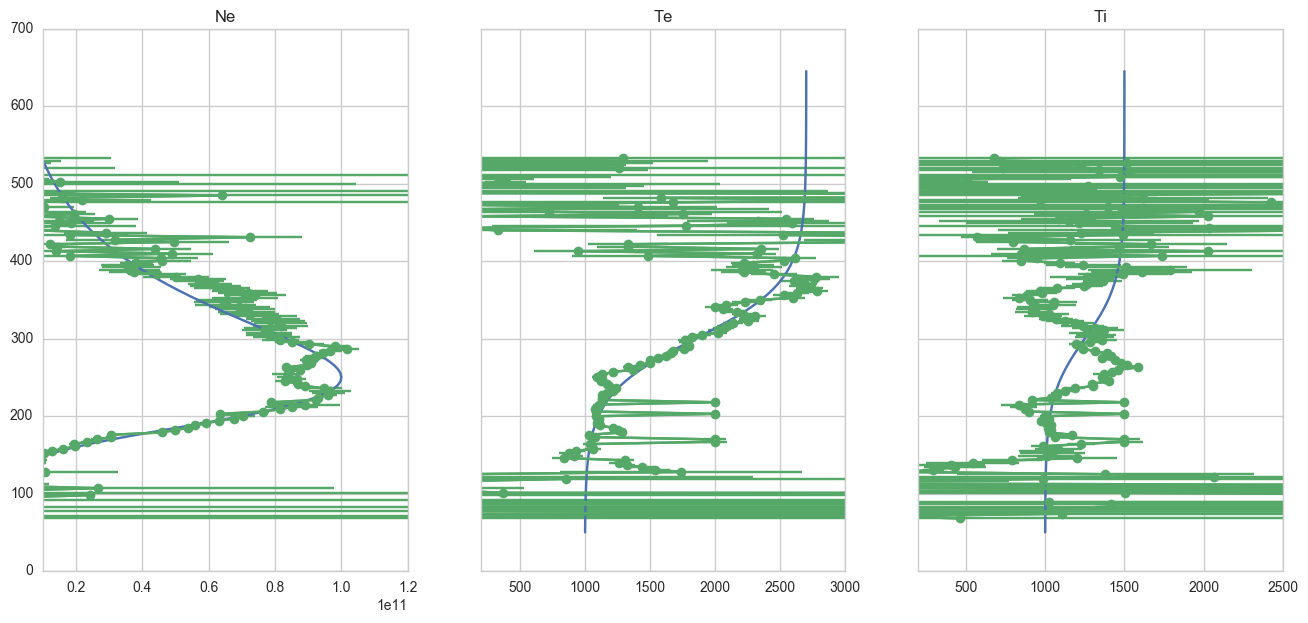

In [5]:
sns.set_style("whitegrid")
sns.set_context("notebook")
fig1,axmat =plt.subplots(1,3,figsize = (16,7),sharey=True)
axvec = axmat.flatten()
fittedfile = os.path.join(testpath,'Fitted','fitteddata.h5')
fitiono = IonoContainer.readh5(fittedfile)
paramlist = ['Ne','Te','Ti']
indlist =[sp.argwhere(ip==fitiono.Param_Names)[0][0] for ip in paramlist]
n_indlist =[sp.argwhere(('n'+ip)==fitiono.Param_Names)[0][0] for ip in paramlist]

altin =Icont1.Cart_Coords[:,2]
altfit = fitiono.Cart_Coords[:,2]

in_ind=[[1,0],[1,1],[0,1]]
pbounds = [[1e10,1.2e11],[200.,3000.],[200.,2500.],[-100.,100.]]
for i,iax in enumerate(axvec):
    iinind = in_ind[i]
    ifitind = indlist[i]
    n_ifitind = n_indlist[i]
    #plot input
    indata = Icont1.Param_List[:,0,iinind[0],iinind[1]]
    iax.plot(indata,altin)
    #plot fitted data
    fitdata = fitiono.Param_List[:,0,ifitind]
    fit_error = fitiono.Param_List[:,0,n_ifitind]
    ploth=iax.plot(fitdata,altfit)[0]
    iax.set_xlim(pbounds[i])
    iax.errorbar(fitdata,altfit,xerr=fit_error,fmt='-o',color=ploth.get_color())
    iax.set_title(paramlist[i])